In [1]:
import os, sys, email
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style('whitegrid')
#import plotly
#plotly.offline.init_notebook_mode()
#import plotly.graph_objs as go
import wordcloud
import networkx as nx
from nltk.tokenize.regexp import RegexpTokenizer
from subprocess import check_output

In [2]:
# Read the data into a DataFrame
emails_df = pd.read_csv('./emails.csv')
print(emails_df.shape)
emails_df.head()

(517401, 2)


,file,message
0,allen-p/_sent_mail/1.,Message-ID: <18782981.1075855378110.JavaMail.e...
1,allen-p/_sent_mail/10.,Message-ID: <15464986.1075855378456.JavaMail.e...
2,allen-p/_sent_mail/100.,Message-ID: <24216240.1075855687451.JavaMail.e...
3,allen-p/_sent_mail/1000.,Message-ID: <13505866.1075863688222.JavaMail.e...
4,allen-p/_sent_mail/1001.,Message-ID: <30922949.1075863688243.JavaMail.e...


In [3]:
# A single message looks like this
print(emails_df['message'][0])

Message-ID: <18782981.1075855378110.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Sent Mail
X-Origin: Allen-P
X-FileName: pallen (Non-Privileged).pst

Here is our forecast

 


In [4]:
## Helper functions
def get_text_from_email(msg):
    '''To get the content from email objects'''
    parts = []
    for part in msg.walk():
        if part.get_content_type() == 'text/plain':
            parts.append( part.get_payload() )
    return ''.join(parts)

def split_email_addresses(line):
    '''To separate multiple email addresses'''
    if line:
        addrs = line.split(',')
        addrs = frozenset(map(lambda x: x.strip(), addrs))
    else:
        addrs = None
    return addrs

In [5]:
# Parse the emails into a list email objects
messages = list(map(email.message_from_string, emails_df['message']))
emails_df.drop('message', axis=1, inplace=True)
# Get fields from parsed email objects
keys = messages[0].keys()
for key in keys:
    emails_df[key] = [doc[key] for doc in messages]
# Parse content from emails
emails_df['content'] = list(map(get_text_from_email, messages))
# Split multiple email addresses
emails_df['From'] = emails_df['From'].map(split_email_addresses)
emails_df['To'] = emails_df['To'].map(split_email_addresses)

# Extract the root of 'file' as 'user'
emails_df['user'] = emails_df['file'].map(lambda x:x.split('/')[0])
del messages

emails_df.head()

,file,Message-ID,Date,From,To,Subject,Mime-Version,Content-Type,Content-Transfer-Encoding,X-From,X-To,X-cc,X-bcc,X-Folder,X-Origin,X-FileName,content,user
0,allen-p/_sent_mail/1.,<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Tim Belden <Tim Belden/Enron@EnronXGate>,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Here is our forecast\n\n,allen-p
1,allen-p/_sent_mail/10.,<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,John J Lavorato <John J Lavorato/ENRON@enronXg...,,,"\Phillip_Allen_Jan2002_1\Allen, Phillip K.\'Se...",Allen-P,pallen (Non-Privileged).pst,Traveling to have a business meeting takes the...,allen-p
2,allen-p/_sent_mail/100.,<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Leah Van Arsdall,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,test successful. way to go!!!,allen-p
3,allen-p/_sent_mail/1000.,<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Randall L Gay,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,"Randy,\n\n Can you send me a schedule of the s...",allen-p
4,allen-p/_sent_mail/1001.,<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,1.0,text/plain; charset=us-ascii,7bit,Phillip K Allen,Greg Piper,,,\Phillip_Allen_Dec2000\Notes Folders\'sent mail,Allen-P,pallen.nsf,Let's shoot for Tuesday at 11:45.,allen-p


In [6]:
print('shape of the dataframe:', emails_df.shape)
# Find number of unique values in each columns
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

shape of the dataframe: (517401, 18)
file 517401
Message-ID 517401
Date 224128
From 20328
To 54748
Subject 159290
Mime-Version 1
Content-Type 2
Content-Transfer-Encoding 3
X-From 27980
X-To 73552
X-cc 33701
X-bcc 132
X-Folder 5335
X-Origin 259
X-FileName 429
content 249025
user 150


In [7]:
# Set index and drop columns with two few values
emails_df = emails_df.set_index('Message-ID').drop(['file', 'Mime-Version', 'Content-Type', 'Content-Transfer-Encoding', 'X-FileName', 'X-Origin', 'X-Folder', 'X-bcc', 'X-cc', 'user', 'X-From', 'X-To'], axis=1)
# Parse datetime
# emails_df['Date'] = pd.to_datetime(emails_df['Date'], infer_datetime_format=True)
# emails_df.dtypes

In [8]:
emails_df.head()

,Date,From,To,Subject,content
Message-ID,,,,,
<18782981.1075855378110.JavaMail.evans@thyme>,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,Here is our forecast\n\n
<15464986.1075855378456.JavaMail.evans@thyme>,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...
<24216240.1075855687451.JavaMail.evans@thyme>,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!
<13505866.1075863688222.JavaMail.evans@thyme>,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,"Randy,\n\n Can you send me a schedule of the s..."
<30922949.1075863688243.JavaMail.evans@thyme>,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.


In [9]:
for col in emails_df.columns:
    print(col, emails_df[col].nunique())

Date 224128
From 20328
To 54748
Subject 159290
content 249025


In [10]:
print(emails_df.shape)
emails_df = emails_df[emails_df['From'] != emails_df['To']]
print(emails_df.shape)

(517401, 5)
(501106, 5)


(-0.5, 799.5, 599.5, -0.5)

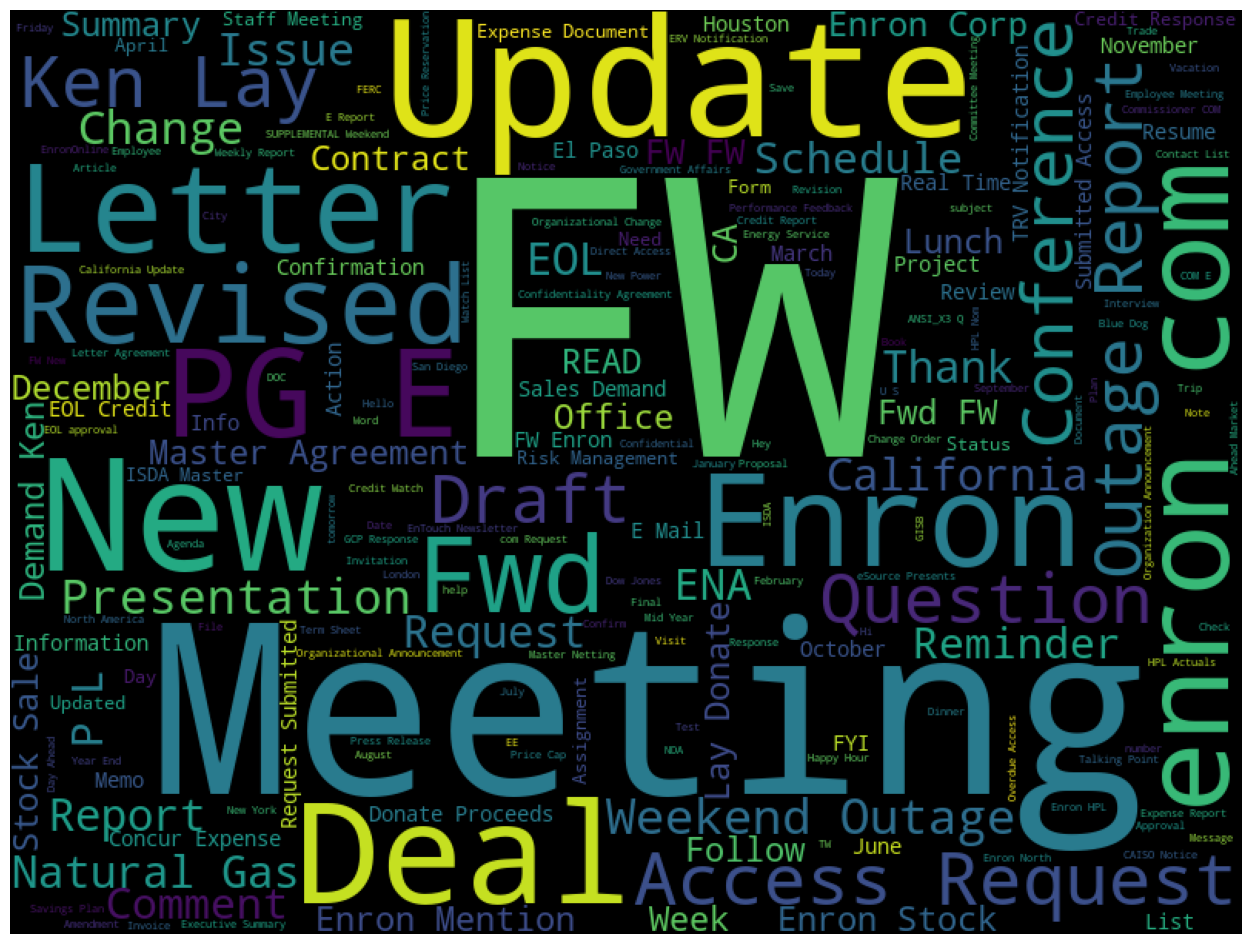

In [11]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

subjects = ' '.join(emails_df['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

In [12]:
emails_df = emails_df.reset_index(drop=True)
emails_df.head()

,Date,From,To,Subject,content
0,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",(phillip.allen@enron.com),(tim.belden@enron.com),,Here is our forecast\n\n
1,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...
2,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!
3,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",(phillip.allen@enron.com),(randall.gay@enron.com),,"Randy,\n\n Can you send me a schedule of the s..."
4,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.


In [13]:
emails_df.rename(columns={'content': 'Body'}, inplace=True)

date_df = emails_df['Date']
# Using regex to replace the timezone abbreviation
date_df = date_df.str.replace(r'\s-\d{4}\s\([A-Z]+\)$', '', regex=True)
date_time_df = pd.to_datetime(date_df, format='mixed')
emails_df['Date'] = date_time_df.dt.date
emails_df['Time'] = date_time_df.dt.time
emails_df.head()

,Date,From,To,Subject,Body,Time
0,2001-05-14,(phillip.allen@enron.com),(tim.belden@enron.com),,Here is our forecast\n\n,16:39:00
1,2001-05-04,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...,13:51:00
2,2000-10-18,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!,03:00:00
3,2000-10-23,(phillip.allen@enron.com),(randall.gay@enron.com),,"Randy,\n\n Can you send me a schedule of the s...",06:13:00
4,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.,05:07:00


In [14]:
syn_email_df = pd.read_csv('./varied_email_dataset.csv')
syn_email_df.head()

,From,To,Subject,Sent Time,Meeting Date,Meeting Time,Platform,Body
0,ghunt@example.org,jessica59@example.org,Formal Meeting Invitation,2024-04-10 06:25:30,2024-04-12,10:30:59,Zoom,For the upcoming review of operational efficie...
1,chasele@example.com,jdavis@example.net,Scheduled Team Meeting,2024-04-21 16:26:55,2024-04-23,12:54:53,Google Meet,To participate in the upcoming policy review m...
2,robert72@example.com,kirstenvasquez@example.net,Project Discussion Invite,2024-04-10 07:15:23,2024-04-18,23:42:49,Zoom,To participate in the upcoming policy review m...
3,stoneadam@example.org,johnsongeorge@example.org,Scheduled Team Meeting,2024-04-06 16:39:15,2024-04-03,16:03:47,Zoom,This is a reminder to attend the upcoming meet...
4,kimmichael@example.org,popediane@example.org,Project Discussion Invite,2024-04-16 17:42:18,2024-04-07,08:11:08,Google Meet,The team meeting will take place using the fol...


In [15]:
syn_email_df = syn_email_df.drop(['Meeting Date', 'Meeting Time', 'Platform'] ,axis=True)
date_df = syn_email_df['Sent Time']
syn_email_df = syn_email_df.drop('Sent Time', axis=True)
date_time_df = pd.to_datetime(date_df, format='mixed')
syn_email_df['Date'] = date_time_df.dt.date
syn_email_df['Time'] = date_time_df.dt.time
syn_email_df.head()

,From,To,Subject,Body,Date,Time
0,ghunt@example.org,jessica59@example.org,Formal Meeting Invitation,For the upcoming review of operational efficie...,2024-04-10,06:25:30
1,chasele@example.com,jdavis@example.net,Scheduled Team Meeting,To participate in the upcoming policy review m...,2024-04-21,16:26:55
2,robert72@example.com,kirstenvasquez@example.net,Project Discussion Invite,To participate in the upcoming policy review m...,2024-04-10,07:15:23
3,stoneadam@example.org,johnsongeorge@example.org,Scheduled Team Meeting,This is a reminder to attend the upcoming meet...,2024-04-06,16:39:15
4,kimmichael@example.org,popediane@example.org,Project Discussion Invite,The team meeting will take place using the fol...,2024-04-16,17:42:18


In [16]:
print(emails_df.shape, syn_email_df.shape)
all_email_df = pd.concat([emails_df, syn_email_df])
print(all_email_df.shape)
all_email_df.head()

(501106, 6) (3000, 6)
(504106, 6)


,Date,From,To,Subject,Body,Time
0,2001-05-14,(phillip.allen@enron.com),(tim.belden@enron.com),,Here is our forecast\n\n,16:39:00
1,2001-05-04,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...,13:51:00
2,2000-10-18,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!,03:00:00
3,2000-10-23,(phillip.allen@enron.com),(randall.gay@enron.com),,"Randy,\n\n Can you send me a schedule of the s...",06:13:00
4,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.,05:07:00


In [17]:
has_missing = all_email_df.isna().sum()

print(has_missing)

Date           0
From           0
To         21847
Subject        0
Body           0
Time           0
dtype: int64


In [18]:
print(all_email_df.shape)

(504106, 6)


In [19]:
all_email_df.head()

,Date,From,To,Subject,Body,Time
0,2001-05-14,(phillip.allen@enron.com),(tim.belden@enron.com),,Here is our forecast\n\n,16:39:00
1,2001-05-04,(phillip.allen@enron.com),(john.lavorato@enron.com),Re:,Traveling to have a business meeting takes the...,13:51:00
2,2000-10-18,(phillip.allen@enron.com),(leah.arsdall@enron.com),Re: test,test successful. way to go!!!,03:00:00
3,2000-10-23,(phillip.allen@enron.com),(randall.gay@enron.com),,"Randy,\n\n Can you send me a schedule of the s...",06:13:00
4,2000-08-31,(phillip.allen@enron.com),(greg.piper@enron.com),Re: Hello,Let's shoot for Tuesday at 11:45.,05:07:00


In [20]:
seed = 42
all_email_df = all_email_df.sample(frac=1, random_state=seed).reset_index(drop=True)
all_email_df.head()

,Date,From,To,Subject,Body,Time
0,2000-02-15,(pamela.chambers@enron.com),"(howard.camp@enron.com, robert.lloyd@enron.com...",Three Rivers Mtg. EB37C1,2/15/00\n\nPlease see attachment \n\n\n\n\nIf ...,05:46:00
1,2000-11-16,(enron.announcements@enron.com),(houston.report@enron.com),Weekend Outage for 11-17-00 through 11-20-00,----------------------------------------------...,10:08:00
2,2001-05-22,(greg.piper@enron.com),(greg.whalley@enron.com),"EnronOnline, etc.",Did you talk to Dynegy about buying the engine...,12:22:00
3,2001-02-21,(enron.announcements@enron.com),(all.houston@enron.com),Get Out Your Light Saber,. . . STAR WARS IS COMING TO HOUSTON!\n\nClick...,16:10:00
4,2001-07-24,(jeff.dasovich@enron.com),(sgovenar@govadv.com),Rumor That The Legislature May Reconvene,"Bizarre as it sounds, we've now heard that the...",12:02:00


In [21]:
import re

numeral_to_word = {
    '0': 'zero ', '1': 'one ', '2': 'two ', '3': 'three ', '4': 'four ',
    '5': 'five ', '6': 'six ', '7': 'seven ', '8': 'eight ', '9': 'nine '
}

def clean_text(text):
    text = text.lower()
    # Remove special characters
    cleaned_text = text.replace('\n', ' ')
    cleaned_text = re.sub(r'[^\w\s]', '', text)
    # Replace numerals with words
#     for numeral, word in numeral_to_word.items():
#         cleaned_text = cleaned_text.replace(numeral, word)
    # Remove extra whitespace
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    return cleaned_text

all_email_df['Body'] = all_email_df['Body'].apply(clean_text)

In [22]:
all_email_df.head()

,Date,From,To,Subject,Body,Time
0,2000-02-15,(pamela.chambers@enron.com),"(howard.camp@enron.com, robert.lloyd@enron.com...",Three Rivers Mtg. EB37C1,21500 please see attachment if you have any qu...,05:46:00
1,2000-11-16,(enron.announcements@enron.com),(houston.report@enron.com),Weekend Outage for 11-17-00 through 11-20-00,w e e k e n d s y s t e m s a v a i l a b i l ...,10:08:00
2,2001-05-22,(greg.piper@enron.com),(greg.whalley@enron.com),"EnronOnline, etc.",did you talk to dynegy about buying the engine...,12:22:00
3,2001-02-21,(enron.announcements@enron.com),(all.houston@enron.com),Get Out Your Light Saber,star wars is coming to houston click here for ...,16:10:00
4,2001-07-24,(jeff.dasovich@enron.com),(sgovenar@govadv.com),Rumor That The Legislature May Reconvene,bizarre as it sounds weve now heard that they ...,12:02:00


In [23]:
def classify_email(email_text):
    meeting_keywords = [
        'meeting', 'session', 'discussing', 'looking forward', 
        'planned', 'workshop', 'training', 'review', 'planning',
        'scheduled', 'upcoming', 'quarterly', 'monthly', 'weekly',
        'join', 'attend', 'participate', 'access', 'follow',
        'prepare', 'review', 'finalize', 'discuss', 'cover',
        'required to attend', 'crucial', 'mandatory', 'attending',
        'meet', 'discussed', 'go through', 'check-in', 'connect',
        'webinar', 'reviewed', 'presentation', 'availability', 
        'catch up', 'call', 'called', 'set up', 'available', 'sync up',
        'caught up', 'talk', 'chat', 'time', 'plan', 'to go over', 
        'as soon as possible', 'asap', 'earliest convenience',
        'conference'
    ]
    
    if any(keyword in email_text.lower() for keyword in meeting_keywords):
        return 'Meeting-related'
    else:
        return False

In [24]:
print(all_email_df.shape)
all_email_df['Class'] = all_email_df['Body'].apply(classify_email)
all_email_df = all_email_df[all_email_df['Class'] != False]
print(all_email_df.shape)

(504106, 6)
(353222, 7)


In [25]:
all_email_df.head()

,Date,From,To,Subject,Body,Time,Class
1,2000-11-16,(enron.announcements@enron.com),(houston.report@enron.com),Weekend Outage for 11-17-00 through 11-20-00,w e e k e n d s y s t e m s a v a i l a b i l ...,10:08:00,Meeting-related
2,2001-05-22,(greg.piper@enron.com),(greg.whalley@enron.com),"EnronOnline, etc.",did you talk to dynegy about buying the engine...,12:22:00,Meeting-related
4,2001-07-24,(jeff.dasovich@enron.com),(sgovenar@govadv.com),Rumor That The Legislature May Reconvene,bizarre as it sounds weve now heard that they ...,12:02:00,Meeting-related
9,2000-09-25,(rosalee.fleming@enron.com),(joe.hillings@enron.com),Re: Selection Of My Successor-My Concern,good morning joe ken is on a cruise so is not ...,03:39:00,Meeting-related
11,1979-12-31,(mary.hain@enron.com),None,Don't forget to register!,to register your palm computingc organizer ele...,16:00:00,Meeting-related


In [26]:
# all_email_df.to_csv('all_emails_meetings.csv', index=False) 

In [27]:
meeting_counts = all_email_df['Class'].value_counts()
print(meeting_counts)

Class
Meeting-related    353222
Name: count, dtype: int64


(-0.5, 799.5, 599.5, -0.5)

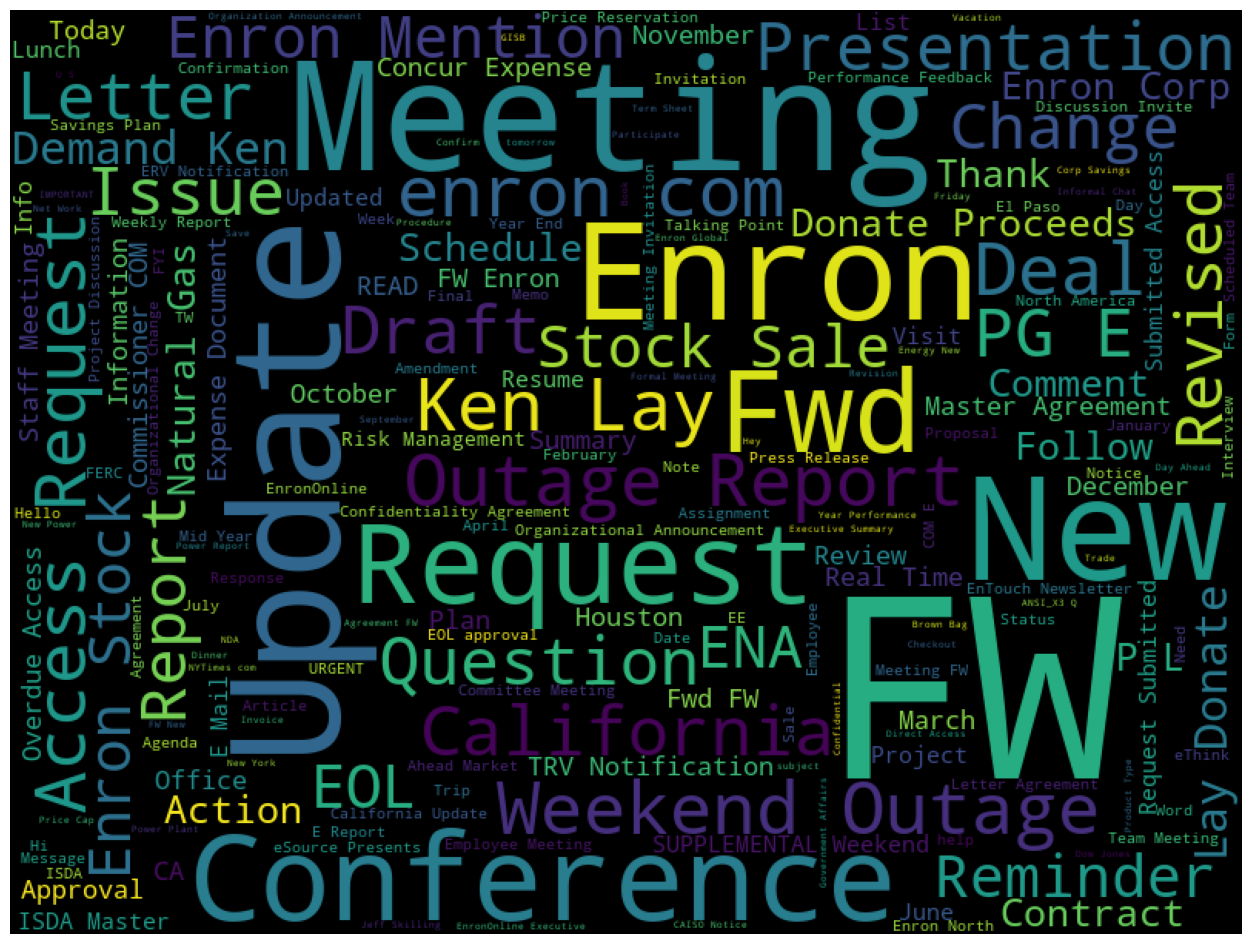

In [28]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

subjects = ' '.join(all_email_df['Subject'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")

(-0.5, 799.5, 599.5, -0.5)

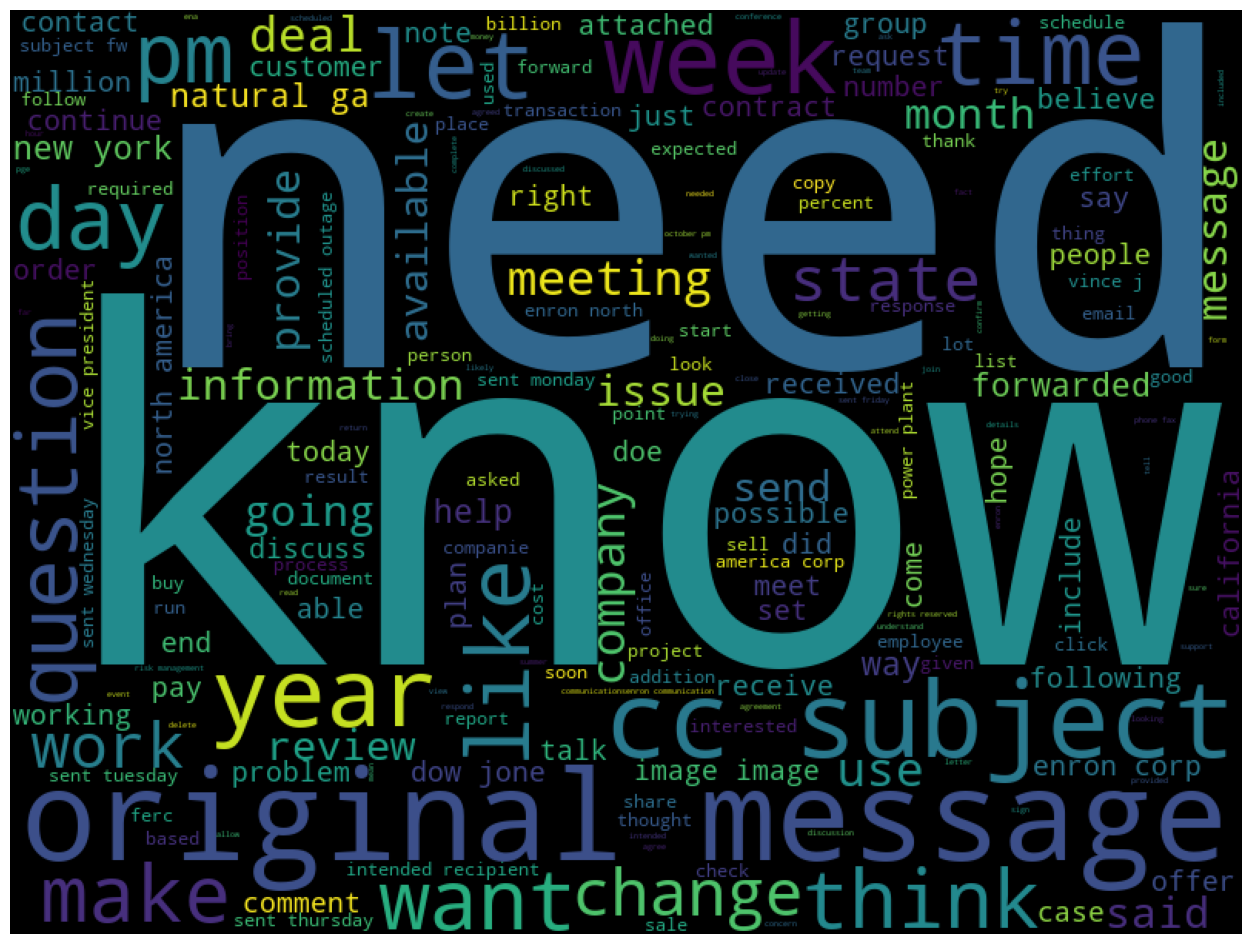

In [29]:
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS

subjects = ' '.join(all_email_df['Body'])
fig, ax = plt.subplots(figsize=(16, 12))
wc = wordcloud.WordCloud(width=800, 
                         height=600, 
                         max_words=200,
                         stopwords=ENGLISH_STOP_WORDS).generate(subjects)
ax.imshow(wc)
ax.axis("off")